In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/My Drive/Colab Notebooks/NYU"

/content/gdrive/My Drive/Colab Notebooks/NYU


In [0]:
import os
modelsPath = "Models/"
os.makedirs( modelsPath, exist_ok=True)

logs_dir="logs/fit/"
os.makedirs( modelsPath, exist_ok=True)


## Standard imports

In [0]:
import sys
import time

import os
import sys
import h5py
import cv2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from scipy.stats import norm
from sklearn import manifold



## Tensorflow/Keras imports


In [5]:
import tensorflow as tf

#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

from tensorflow.keras.utils import plot_model
import IPython

from tensorflow.keras.optimizers import RMSprop

import numpy as np

from random import randint

# Handy parameters
batchSize = 256


## **WARNING: importing something from the Keras project rather than tensorflow.keras**
- The Keras project has lots of useful datasets.  We are only importing the datasets, not any modules !

In [6]:
from keras.datasets import mnist, fashion_mnist, cifar10

Using TensorFlow backend.


In [0]:
latentDim = { "mnist": 32,
              "fashion_mnist": 64,
              "cifar10": 128
            }


## Libary to import/display datasets

In [0]:
def loadData(name="mnist"):
  if name == "mnist":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
  elif name == "cifar10":
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  elif name == "fashion_mnist":
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  else:
    print("Dataset \"{n:s}\" not known.".format(n=name))
    return None
  
  # Make sure data is 3D
  if len(x_train.shape) < 4:
    x_train = x_train[:, :, :, np.newaxis]
    x_test  = x_test[:, :, :, np.newaxis]
    
  # Scale
  x_train, x_test = x_train.astype("float32")/255., x_test.astype("float32")/255.
  return (x_train, y_train), (x_test, y_test)

def showData(imgs,y, max_num=50, y_target=None):
  if len(y.shape) > 1:
    y = y.reshape(-1)
    
  # Filter images to those whose label is target
  if y_target is not None:
    mask = (y == y_target)
    imgs = imgs[ mask ]
    y    = y[ mask ]
    
    # Track the indices too, so we can find the image in imgs
    idxs = np.arange( len(mask) )
    idxs = idxs[ mask ]
    
  if max_num is not None:
    # Randomly choose
    chosen = np.random.randint(0, len(imgs), size=max_num)
    imgs = imgs[chosen]
    y    = y[chosen]
    idxs  = idxs[chosen]
    
  # Plot the images
  num_cols = 5
  num_rows = (len(imgs) // num_cols) + ( len(imgs)  % num_cols != 0 )
  
  fig, axs = plt.subplots( num_rows, num_cols, figsize=(12, 4 * num_rows) )
  axs = axs.ravel()
  
  for i,img in enumerate(imgs):
    ax = axs[i]
    
    showImage(img, ax=ax)
    
    ax.set_title(y[i])
    ax.set_xlabel( idxs[i] )
    ax.set_xticks([])
    ax.set_yticks([])
  
def createModels(shape=(28,28,1), latent_dim=32):
  # input_img = Input(shape=(imageSize, imageSize, 1))
  input_img = Input(shape=shape)
  x = Convolution2D(32, (3, 3), border_mode='same')(input_img)
  x = ELU()(x)
  x = MaxPooling2D((2, 2), border_mode='same')(x)

  x = Convolution2D(64, (3, 3), border_mode='same')(x)
  x = ELU()(x)
  x = MaxPooling2D(pool_size=(2, 2), border_mode='same')(x)

  # Latent space // bottleneck layer
  x = Flatten()(x)
  x = Dense(latent_dim)(x)
  z = ELU()(x)

  ##### MODEL 1: ENCODER #####
  encoder = Model(input_img, z)

  # We instantiate these layers separately so as to reuse them for the decoder
  # Dense from latent space to image dimension
  # Encoder has two layers of (2,2) pooling so size reduced by factor of 4
  encoded_shape=np.array(shape[0:2])//4
  encoded_size = np.prod(encoded_shape)
                 
  x_decoded_dense1 = Dense(encoded_size * 64)

  # Reshape for image
  x_decoded_reshape0 = Reshape((encoded_shape[0], encoded_shape[1], 64))
  x_decoded_upsample0 = UpSampling2D((2, 2))
  x_decoded_conv0  = Convolution2D(32, (3, 3), border_mode='same')

  x_decoded_upsample3 = UpSampling2D((2, 2))
  x_decoded_conv3 = Convolution2D(shape[-1], (3, 3), activation='sigmoid', border_mode='same')

  # Create second part of autoencoder
  x_decoded = x_decoded_dense1(z)
  x_decoded = ELU()(x_decoded)

  x_decoded = x_decoded_reshape0(x_decoded)
  x_decoded = x_decoded_upsample0(x_decoded)
  x_decoded = x_decoded_conv0(x_decoded)
  x_decoded = ELU()(x_decoded)

  # Tanh layer
  x_decoded = x_decoded_upsample3(x_decoded)
  decoded_img = x_decoded_conv3(x_decoded)

  ##### MODEL 2: AUTO-ENCODER #####
  autoencoder = Model(input_img, decoded_img)

  # Create decoder
  input_z = Input(shape=(latent_dim,))
  x_decoded_decoder = x_decoded_dense1(input_z)
  x_decoded_decoder = ELU()(x_decoded_decoder)

  x_decoded_decoder = x_decoded_reshape0(x_decoded_decoder)
  x_decoded_decoder = x_decoded_upsample0(x_decoded_decoder)
  x_decoded_decoder = x_decoded_conv0(x_decoded_decoder)
  x_decoded_decoder = ELU()(x_decoded_decoder)

  # Tanh layer
  x_decoded_decoder = x_decoded_upsample3(x_decoded_decoder)
  decoded_decoder_img = x_decoded_conv3(x_decoded_decoder)

  ##### MODEL 3: DECODER #####
  decoder = Model(input_z, decoded_decoder_img)

  return autoencoder, encoder, decoder

def trainModel(model, X, X_test, epochs=20, callbacks=[], loss="mse", metrics=[]):
    model.compile(optimizer=RMSprop(lr=0.00025), loss=loss, metrics=metrics)
    history = model.fit(X, X, epochs=epochs, batch_size=batchSize, validation_data=(X_test, X_test), shuffle=True, callbacks=callbacks)
    return history
  
def plot_training(history, metrics=[], title=None):
    """
    Plot training and validation statistics
    - accuracy vs epoch number
    - loss     vs epoch number

    From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
    """  

    # Loss
    loss = history.history['loss']

    epochs = range(len(loss))

    plot_num = 1
    fig = plt.figure()
    ax = fig.add_subplot(1, 1 +len(metrics), plot_num)
    plot_num += 1
    
    _= ax.plot(epochs, loss, 'b', label='Training loss')
    _= ax.set_title("Training loss " + title if title is not None else "")
    _= ax.set_xlabel("Epoch")
    
    plot_num = 1
    for metric in metrics:
      metric_value = history.history[metric]
      ax = fig.add_subplot(1, 1 +len(metrics), plot_num)
      plot_num += 1
      
      _= ax.plot(epochs, metric_value, 'b', label="Training " + metric)
      _= ax.set_title("Training " + metric + " " + title if title is not None else "")
      _= ax.set_xlabel("Epoch")
      
    # fig.set_visible(False)
    # plt.draw()
    
    return fig
    
def showImage(img, ax=plt, cmap=None):
  # Some datasets (e.g., MNIST) have only 1 channel instead of 3
  if img.shape[-1] == 1:
    img = img[:,:, 0]
    cmap = "gray"
  
  
  if cmap is None:
    _= ax.imshow(img)
  else:
    _= ax.imshow(img, cmap=cmap)
  

## Library for Vanilla Autoencoder demo

In [9]:

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


def createOneLayerAE(shape=(28,28,1), latent_dim=32, activations=["relu", "sigmoid"]):
  """
  Create a single layer Autoencoder
  
  Parameters
  ----------
  shape: Tuple.  Shape of the input image.  Last dimension is number of channels (depth)
  latent_dim: Int.  Size of the latent representation (encoded image)
  activations: List
    activations[0]:  activation to apply to encoder (Dense layer) output
    activations[-1]: activation to apply to decoder (Dense layer) output
    
  Returns
  -------
  (autoencoder, encoder, decoder) A tuple of Keras MOdel objects, one each for
    the autoencoder and its subcomponents: the encoder and the decoder
  
  """
  
  # Define the encoder
  # Placeholder for input image 
  input_img = Input(shape=shape)
  
  # Flatten the input
  input_img_flat = Flatten()(input_img)
  
  # "encoded" is the encoded representation of the input
  encoded = Dense(latent_dim, activation=activations[0])(input_img_flat)
  
  ##### MODEL 1: ENCODER #####
  encoder = Model(input_img, encoded)
  
  
  # Define the decoder
  # Placeholder for encoded (latent) representation of an image
  input_encoded = Input(shape=(latent_dim,))
  
  # Undo the encoding by following the encoding steps in reverse order
  shape_flat = np.prod( np.array(shape) )
  decoded = Dense(shape_flat, activation=activations[-1], name="decoder_layer")(input_encoded)
  
  # Reshape (flattened) output of decoder to same shape as original input
  reshape_layer = Reshape(shape)
  decoded = reshape_layer(decoded)
  
  ##### MODEL 2: DECODER #####
  # this model maps an input to its reconstruction
  decoder = Model(input_encoded, decoded)
  
  
  ##### MODEL 3: Autoencoder #####
  autoencoder = Model(input_img, decoder(encoder(input_img)))
    
  return autoencoder, encoder, decoder


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Load a dataset

In [0]:
dsName = "mnist"
modelName2 = "autoencoder2_{n:s}.h5".format(n=dsName)


In [11]:
print("Loading dataset...")
(X_train, y_train), (X_test, y_test) = loadData(name=dsName)

imageSize = X_train.shape[1]

X_train.shape, y_train.shape
#X_test.shape,  y_test.shape

Loading dataset...
11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (60000,))

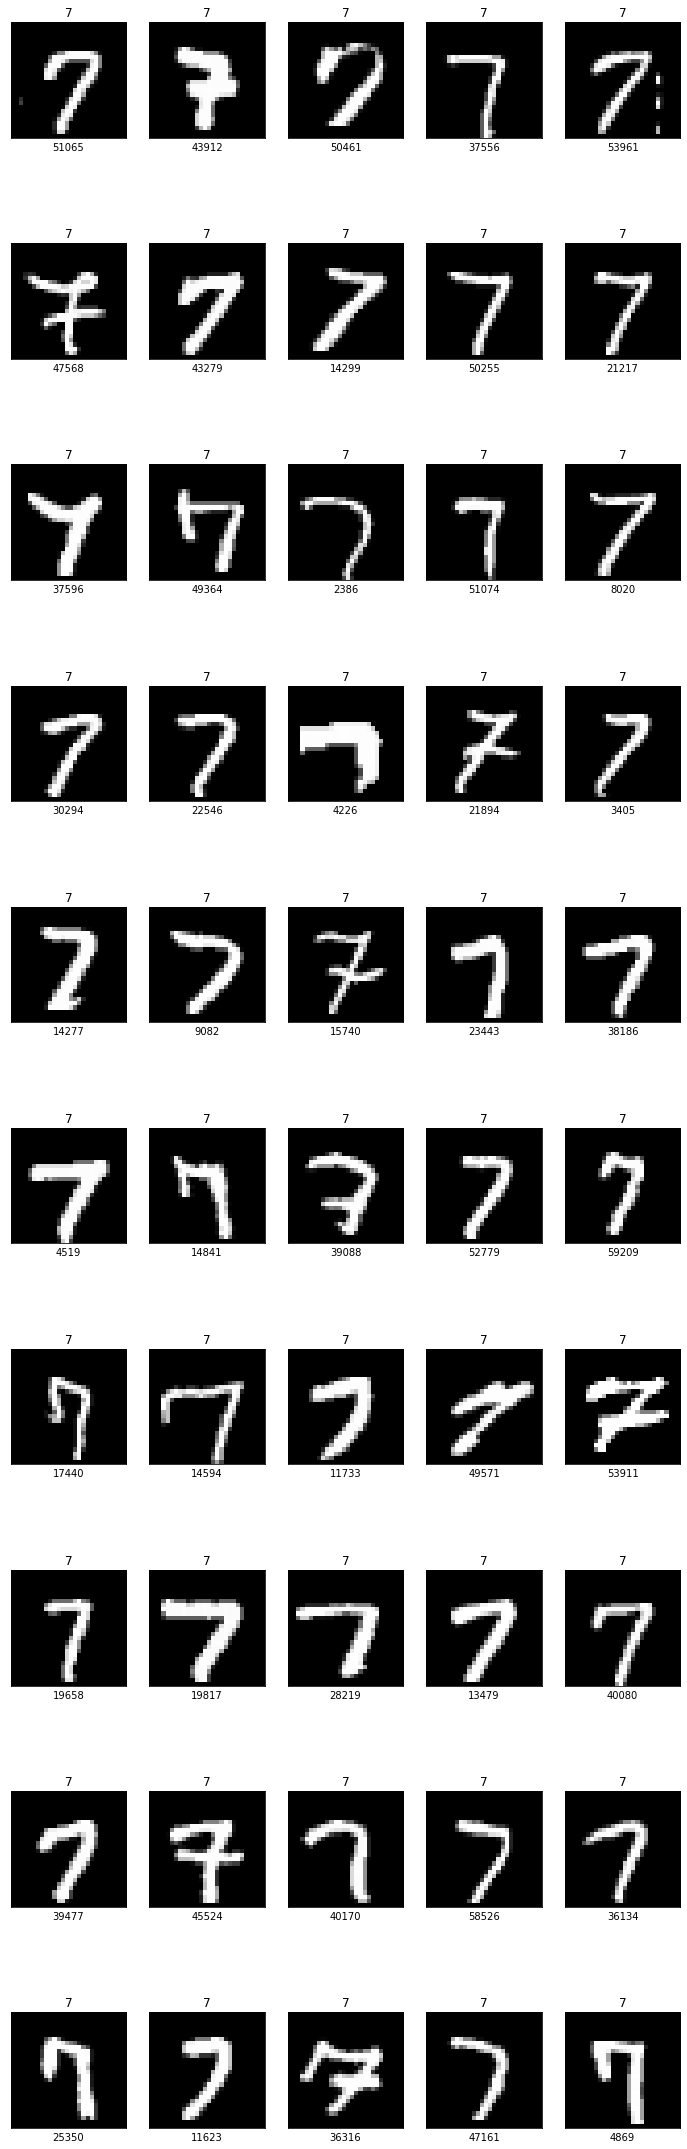

In [12]:
showData( X_train, y_train, y_target=7, max_num=50)

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
log_dir= logs_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [14]:
X_train.shape

(60000, 28, 28, 1)

# Vanilla Autoencoder demo



Training  PCA full  on  mnist  with  {'latent_dim': 784, 'activations': [None, None]}
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0255 - val_loss: 0.0082
Epoch 2/30
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0058 - val_loss: 0.0040
Epoch 3/30
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0033 - val_loss: 0.0025
Epoch 4/30
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0023 - val_loss: 0.0019
Epoch 5/30
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 6/30
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0013 - val_loss: 0.0012
Epoch 7/30
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 8/30
60000/60000 [==============================] - 2s 26us/sample - loss: 9.5853e-04 - val_loss: 0.0011
E

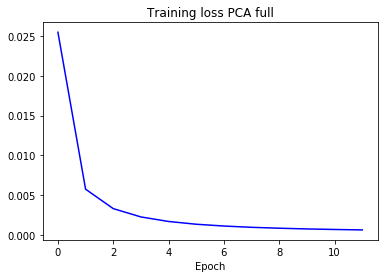

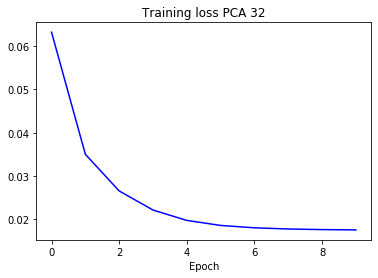

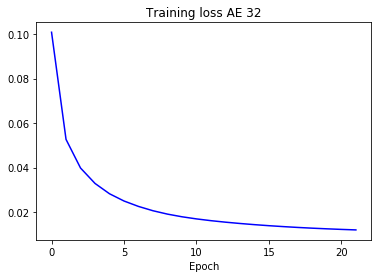

In [15]:
doTrain = True
epochs = 30

modelNamePat = "autoencoder_{name:s}_mnist.h5"

metrics = []

# We will create many models. The following give specifications for each
tests = { "PCA full": { "model args":{ "latent_dim": 784, "activations": [None, None]}, "other args": { "min_delta": .00005} },
          "PCA 32":   { "model args":{ "latent_dim":  32, "activations": [None, None]}, "other args": { "min_delta": .0005} },
          "AE 32":    { "model args":{ "latent_dim":  32}, "other args": { "min_delta": .0005} }
        }

if doTrain:
  # Train the models
 
  # Results of each model will be stored in results[label]
  results = {}
  
  # Train all the models
  for label, specs in tests.items():
    # Extract the test specifications
    model_args, other_args = specs["model args"], specs["other args"]
    latent_dim = model_args["latent_dim"]
    print("\n\nTraining ", label, " on ", dsName, " with ", model_args)
    
    # Per model names, files, etc.
    modelName = modelNamePat.format(name="_".join( ("ae", label, str(latent_dim)) )  )
    weightsFile = os.path.join(modelsPath, modelName)
    graphFile = "_".join( ("ae", label, str(latent_dim)) ) + ".png"
    
    # Create the autoencoder along with its encoder and decoder parts
    autoencoder, encoder, decoder = createOneLayerAE(shape=X_train[0].shape, **model_args)
    
    # Create Early Stopping call back for training
    # Optional min_delta for early stopping of training
    if "min_delta" in other_args:
      min_delta = other_args["min_delta"]
    else:
      min_delta = .001
      
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    # Create callbacks                                  
    callbacks = [ es_callback,
                ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_loss', save_best_only=True)
                ]
       
    # Train the model
    history = trainModel(autoencoder, X_train, X_test, epochs=epochs, loss="mse", callbacks=callbacks, metrics=metrics)
    
    # Save this model's weights
    autoencoder.save_weights(weightsFile, overwrite=True)

    # Create plot of graph for this model's autoencoder
    plot_model(autoencoder, to_file=graphFile, show_shapes=True)
    
    # Create plot of training history
    fig = plot_training(history, metrics, title=label)
    
    # Save the results of this model for later use
    results[label] = { "fig": fig,
                       "weightsFile": weightsFile,
                       "graphFile": graphFile,
                       "autoencoder": autoencoder, 
                       "encoder": encoder, 
                       "decoder": decoder,
                       "history": history
                       }



## Examine full dimension PCA

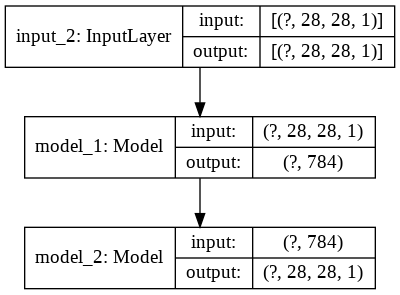

In [16]:
results_pca = results["PCA full"]
fig_pca, graph_pca, ae_pca = [ results_pca[l] for l in ("fig", "graphFile", "autoencoder")]


IPython.display.Image(graph_pca)


In [17]:
ae_pca.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_1 (Model)              (None, 784)               615440    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         615440    
Total params: 1,230,880
Trainable params: 1,230,880
Non-trainable params: 0
_________________________________________________________________


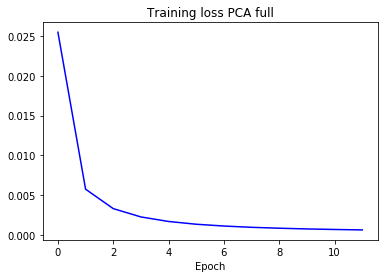

In [18]:
fig_pca

## Examine Autoencoder with bottleneck of 32 units

In [0]:
results_ae32 = results["AE 32"]
fig_ae32, graph_ae32, ae_ae32, decoder_ae32, encoder_ae32 = [ results_ae32[l] for l in ("fig", "graphFile", "autoencoder", "decoder", "encoder")]

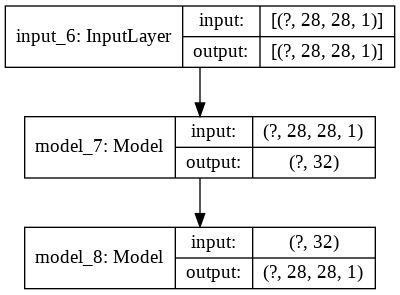

In [20]:
IPython.display.Image(graph_ae32)

In [21]:
ae_ae32.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_7 (Model)              (None, 32)                25120     
_________________________________________________________________
model_8 (Model)              (None, 28, 28, 1)         25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


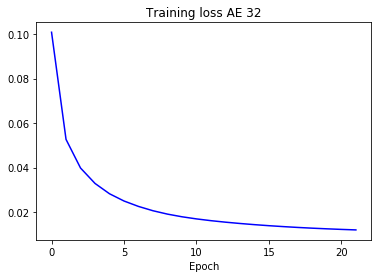

In [22]:
fig_ae32

## Let's encode, then decode some examples to see the loss

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder_ae32.predict(X_test)
decoded_imgs = decoder_ae32.predict(encoded_imgs)


In [24]:
decoded_imgs.shape

(10000, 28, 28, 1)

### Plot description
- First row: test image
- Second row: reconstructed test image

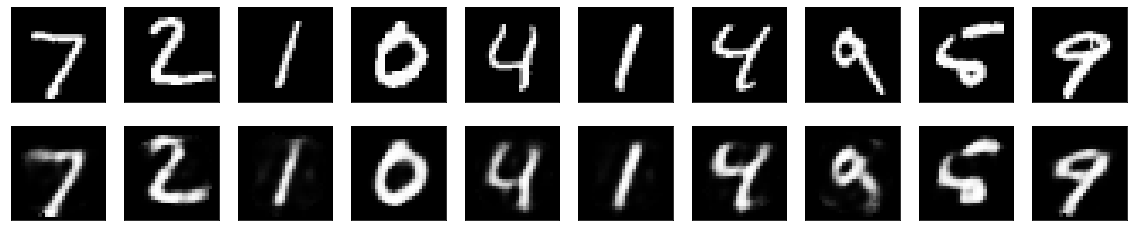

In [25]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Autencoder demo

From: Keras examples https://github.com/keras-team/keras/blob/master/examples/mnist_denoising_autoencoder.py

- This will build a multi-layer Autoencoder with a latent representation of length 16
- It will first add noise to the input *but the target* will be the uncorrupted input
- The layers
  - a Conv2D layer with 32 features (activation maps)
  - a Conv2D layer with 64 features
  - a Dense layer with 16 units

In [0]:
'''Trains a denoising autoencoder on MNIST dataset.

Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.

Noise + Data ---> Denoising Autoencoder ---> Data

Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.

This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



In [0]:
np.random.seed(1337)

# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]



In [0]:
# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = tf.keras.backend.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')


# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')


# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')




## The encoder

In [29]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


## The decoder

In [30]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0   

In [31]:
min_delta=.001
modelName = modelNamePat.format(name="_".join( ("ae", "noisy", str(latent_dim)) )  )
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# Create callbacks                                  
callbacks = [ es_callback,
              #ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_loss', save_best_only=True)
            ]

autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks
               )



Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 11s 187us/sample - loss: 0.0628 - val_loss: 0.0352
Epoch 2/30
60000/60000 [==============================] - 8s 133us/sample - loss: 0.0275 - val_loss: 0.0229
Epoch 3/30
60000/60000 [==============================] - 8s 136us/sample - loss: 0.0218 - val_loss: 0.0203
Epoch 4/30
60000/60000 [==============================] - 8s 135us/sample - loss: 0.0198 - val_loss: 0.0190
Epoch 5/30
60000/60000 [==============================] - 8s 134us/sample - loss: 0.0186 - val_loss: 0.0180
Epoch 6/30
60000/60000 [==============================] - 8s 135us/sample - loss: 0.0178 - val_loss: 0.0175
Epoch 7/30
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0172 - val_loss: 0.0171
Epoch 8/30
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0168 - val_loss: 0.0167


In [0]:
# Change the "style" from Colab default to plt default
plt.style.use('default')

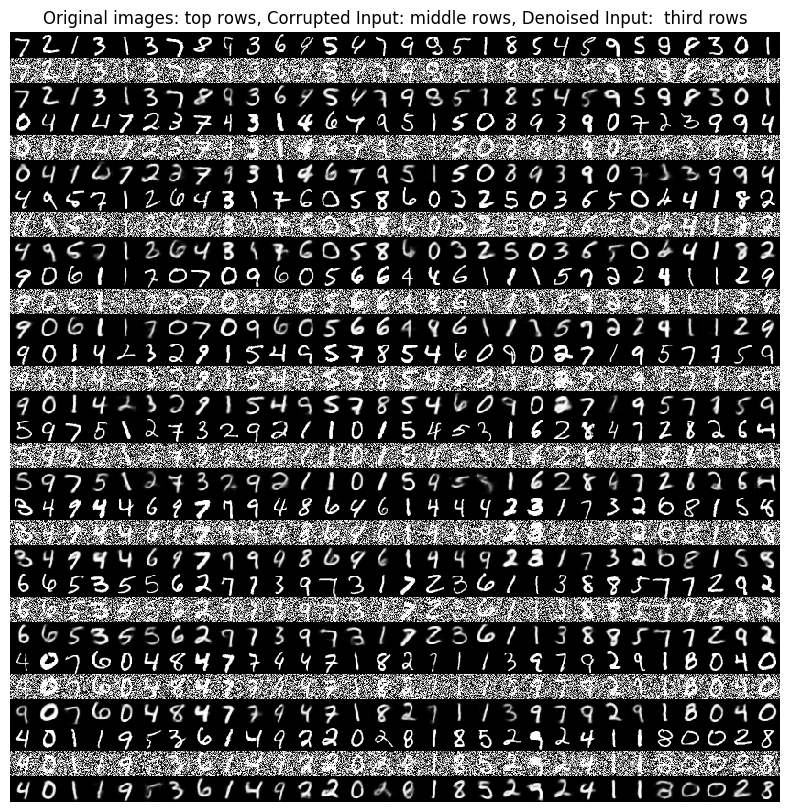

In [33]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure(figsize=(16, 10))
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()


# VAE demo

Derived from https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

In [0]:
'''Example of VAE on MNIST dataset using MLP

The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.

# Reference

[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
# from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os




In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(16, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()




In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50



In [37]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_6[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_6[0][0]                    
____________________________________________________________________________________________

In [0]:

if (False):
  parser = argparse.ArgumentParser()
  help_ = "Load h5 model trained weights"
  parser.add_argument("-w", "--weights", help=help_)
  help_ = "Use mse loss instead of binary cross entropy (default)"
  parser.add_argument("-m",
                      "--mse",
                      help=help_, action='store_true')
  args = parser.parse_args()
else:
  args = {}
  args["mse"]= True
  args["weights"] = None
  
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
if args["mse"]:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)


In [39]:
vae.compile(optimizer='adam')
# vae.summary()

plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

min_delta=.001
modelName = modelNamePat.format(name="_".join( ("ae", "noisy", str(latent_dim)) )  )
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# Create callbacks                                  
callbacks = [ es_callback,
              #ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_loss', save_best_only=True)
            ]

if args["weights"]is not None:
    vae.load_weights(args["weights"])
else:
  # train the autoencoder
  vae.fit(x_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_test, None),
          callbacks=callbacks
         )
  # vae.save_weights('_vae_mlp_mnist.h5')



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 61us/sample - loss: 53.3081 - val_loss: 45.0044
Epoch 2/50
60000/60000 [==============================] - 3s 51us/sample - loss: 44.1323 - val_loss: 43.1211
Epoch 3/50
60000/60000 [==============================] - 3s 51us/sample - loss: 42.9240 - val_loss: 42.3881
Epoch 4/50
60000/60000 [==============================] - 3s 51us/sample - loss: 42.2361 - val_loss: 41.8187
Epoch 5/50
60000/60000 [==============================] - 3s 52us/sample - loss: 41.6314 - val_loss: 41.3849
Epoch 6/50
60000/60000 [==============================] - 3s 50us/sample - loss: 41.0803 - val_loss: 40.7864
Epoch 7/50
60000/60000 [==============================] - 3s 51us/sample - loss: 40.6418 - val_loss: 40.4726
Epoch 8/50
60000/60000 [==============================] - 3s 51us/sample - loss: 40.2916 - val_loss: 40.2131
Epoch 9/50
60000/60000 [==============================] - 3s 50us/sample - los

In [0]:
vae.save_weights('_vae_mlp_mnist.h5')

In [41]:
for l in vae.layers:
  print(l.name)

encoder_input
encoder
decoder
dense_6
z_log_var
z_mean
tf_op_layer_add
tf_op_layer_Square
tf_op_layer_sub
tf_op_layer_Exp
tf_op_layer_SquaredDifference
tf_op_layer_sub_1
tf_op_layer_Mean
tf_op_layer_Sum
tf_op_layer_mul
tf_op_layer_mul_1
tf_op_layer_add_1
tf_op_layer_Mean_1
add_loss


## Vary each dimension of the latent vector, within a range
- On the botton plot
  - horizontal component increases slant from left (low) to high (right) ?
    - also seems to do other things

In [0]:
# Change the "style" from Colab default to plt default
plt.style.use('default')

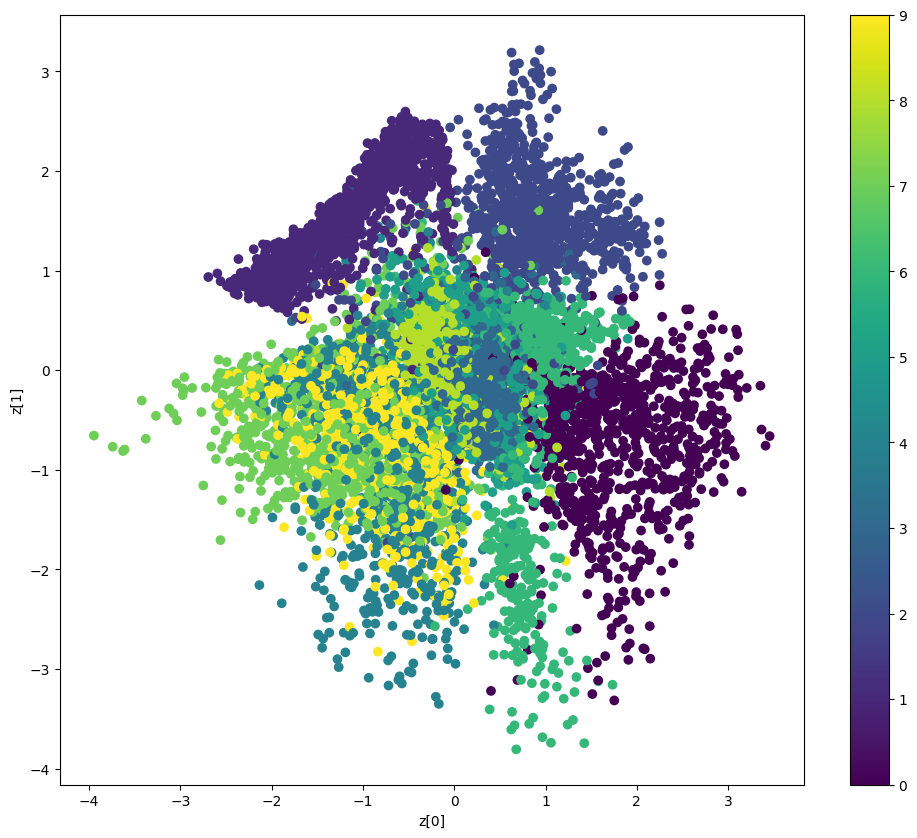

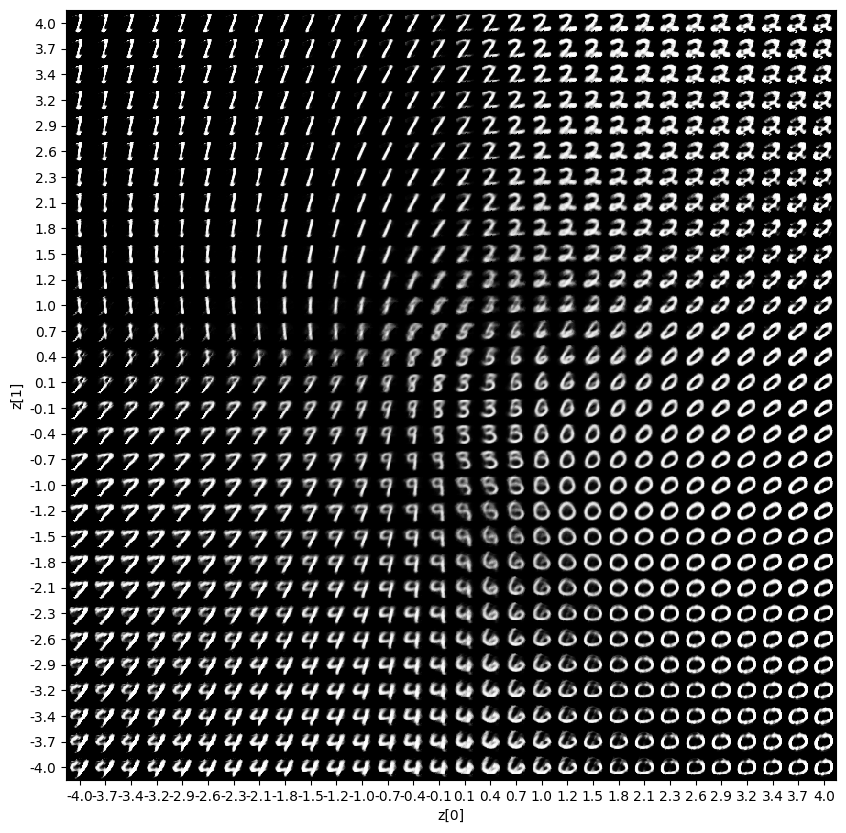

In [43]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")
